In [103]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import pandas as pd

In [104]:
# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [105]:
# c=-1
P2_exp=np.array(df2.iloc[:, 93:])
T2_exp=np.array(df2['Time [s]'])

# T_max=max(T_exp)
# T_exp=T_exp/max(T_exp)
N2_exp=P2_exp.shape[1]


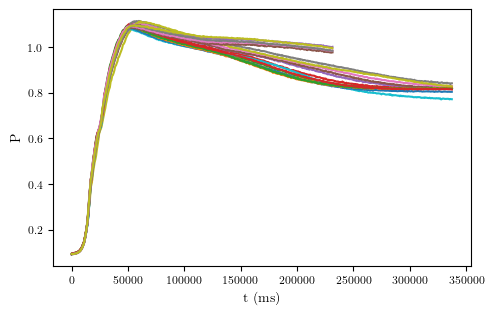

In [106]:

c=-1
P_exp=np.array(df1.iloc[:, 3:].drop('H1',axis=1))[:c]
T_exp=np.array(df1['Time [s]'])[:c]

# T_max=max(T_exp)
# T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]

for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
for i in range(N2_exp):
    plt.plot(T2_exp,P2_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()


### Separamos los casos de kanamycin

In [107]:
P_0=np.array(df2.iloc[:, -5:])
P_125=np.array(df2.iloc[:, 3:9])
P_250=np.array(df2.iloc[:, 9:15])
P_375=np.array(df2.iloc[:, 15:21])
T=np.array(df2['Time [s]'])/df2['Time [s]'].max()


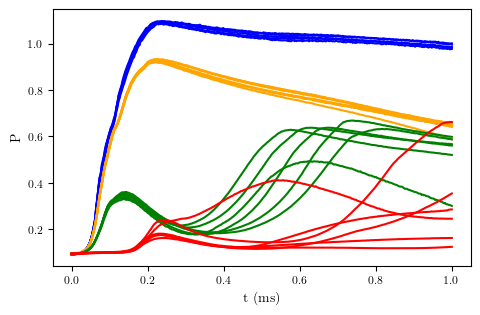

In [108]:
plt.plot(T,P_0, c='blue', label='k=0')
plt.plot(T,P_125,c='orange',label='k=125')
plt.plot(T,P_250,c='green',label='k=250')
plt.plot(T,P_375,c='red',label='k=375')

plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

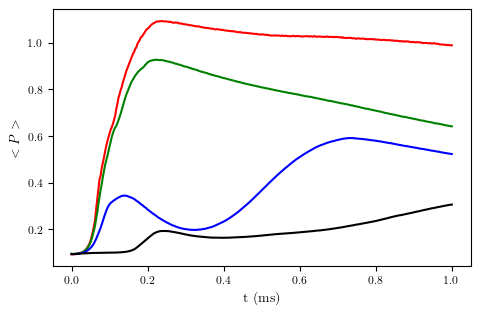

In [109]:
plt.plot(T,np.mean(P_0,axis=1), c='red', label='k=0')
plt.plot(T,np.mean(P_125,axis=1),c='green',label='k=125')
plt.plot(T,np.mean(P_250,axis=1),c='blue',label='k=250')
plt.plot(T,np.mean(P_375,axis=1),c='black',label='k=375')

plt.xlabel('t (ms)')
plt.ylabel(r'$<P>$')
plt.show()

In [110]:
N_f = 100 # Number of residual point
N_d = 700 #Number of data

N_exp=np.array([P_0.shape[1],P_125.shape[1],P_250.shape[1],P_375.shape[1]])
k=[0]*N_exp[0]*len(T)+[1.25]*N_exp[1]*len(T)+[2.5]*N_exp[2]*len(T)+[3.75]*N_exp[3]*len(T)
k=np.array(k).reshape([-1,1])
t=np.tile(T,np.sum(N_exp)).reshape([-1,1])

P_star = np.concatenate((P_0,P_125,P_250,P_375),axis=1).T.flatten()[:,None]
X_star = np.hstack((t,k))

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

# Initial Condition
xx1 = X_star[::len(T)]
uu1 = P_star[::len(T)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.vstack((xx1,xxd))
u_train = np.concatenate((uu1,uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
# X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
u_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)


In [111]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net(t, k, w, b):
    p = DNN(tf.concat([t,k],1),  w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, k, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        p=net(t, k, W_p, b_p)
        phi=net(p, k, W_phi, b_phi)
    p_t = tape1.gradient(p, t) 
    f = p_t - phi
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, lambda_r, lambda_b,opt):
    t_u = X_u_train_tf[:,0:1]
    k_u = X_u_train_tf[:,1:2]
    t_f = X_f_train_tf[:,0:1]
    k_f = X_f_train_tf[:,1:2]


    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi])
        u_nn = net(t_u, k_u, W_p, b_p) 
        f_nn = net_f(t_f, k_f, W_p, b_p, W_phi, b_phi)
        loss_u = tf.square(lambda_b*(u_nn - u_train_tf))
        loss_f = tf.square(lambda_r*f_nn) 
        loss =  tf.reduce_mean(loss_u) + tf.reduce_mean(loss_f)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))

   
    return loss, tf.reduce_mean(tf.square(u_nn - u_train_tf)), tf.reduce_mean(tf.square(f_nn)) 

In [112]:
# N_u = 100 # Number of Initial and Boundary data points


layers = [2, 50, 50, 1]
L = len(layers)

W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b = loss_weight(N_f, N_d)

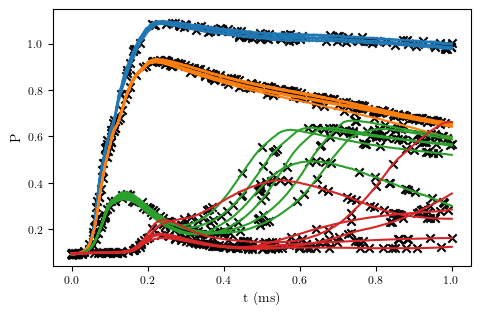

In [113]:
cmap = plt.get_cmap("tab10") 
for i, n in enumerate(N_exp):
    color = cmap(i % 10)
    for j in range(n):
        idx=(np.sum(N_exp[:i])+j)*len(T)
        plt.plot(X_star[:,0:1][idx:idx+len(T)],P_star[idx:idx+len(T)], color=color)

plt.scatter(X_u_train_tf[:,0:1], u_train_tf, marker='x', color='black', label=f'data')  

        
plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()



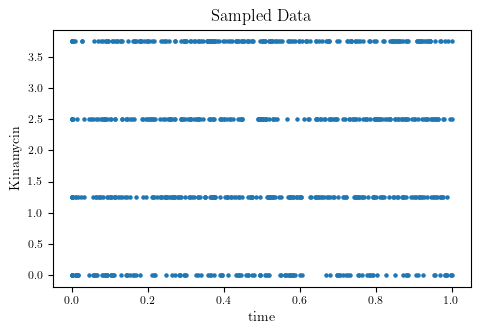

In [114]:
plt.title('Sampled Data')
plt.scatter(X_u_train_tf[:,0:1],X_u_train_tf[:,1:2], s=5)
plt.xlabel('time')
plt.ylabel('Kinamycin')
plt.show()

In [115]:
lr = 1e-4
Nmax = 10**4
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_unk=[]
loss_fis=[]
while n <= Nmax:
    loss_, loss_u, loss_f = train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf,  lambda_r, lambda_b, optimizer)
    loss.append(loss_)
    loss_unk.append(loss_f)

    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u}")
        print(f"Physicial loss is: {loss_f}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 366759.21875
Data loss is: 0.3667590916156769
Physicial loss is: 0.11722463369369507
Iteration is: 10
Total loss is: 338323.15625
Data loss is: 0.33832311630249023
Physicial loss is: 0.07384857535362244
Iteration is: 20
Total loss is: 307466.03125
Data loss is: 0.3074660301208496
Physicial loss is: 0.04096401855349541
Iteration is: 30
Total loss is: 278175.9375
Data loss is: 0.2781759202480316
Physicial loss is: 0.024783367291092873
Iteration is: 40
Total loss is: 252357.140625
Data loss is: 0.2523570954799652
Physicial loss is: 0.017828822135925293
Iteration is: 50
Total loss is: 229403.625
Data loss is: 0.22940361499786377
Physicial loss is: 0.01382147055119276
Iteration is: 60
Total loss is: 208087.46875
Data loss is: 0.2080875039100647
Physicial loss is: 0.010475461371243
Iteration is: 70
Total loss is: 187592.015625
Data loss is: 0.1875920295715332
Physicial loss is: 0.007509403396397829
Iteration is: 80
Total loss is: 167666.03125
Data loss is: 0.16

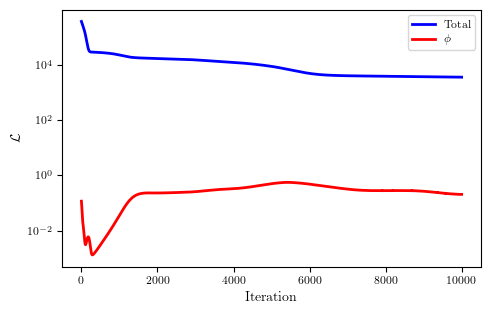

In [116]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_phi_list = [loss_unk[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi$')       


plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [130]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    y_star = X_star_tf[:,1:2]
    u_pred = net(x_star, y_star, w, b)
    return u_pred

## Evaluating total function
k_eval=[0]*len(T)+[1.25]*len(T)+[2.5]*len(T)+[3.75]*len(T)
k_eval=np.array(k_eval).reshape([-1,1])
X_eval=np.hstack((np.tile(T,4).reshape([-1,1]),k_eval))
X_eval_tf = tf.convert_to_tensor(X_eval, dtype=tf.float32)    
u_pred = predict(X_eval_tf, W_p, b_p)
# error_u = np.linalg.norm(P_star-u_pred,2)/np.linalg.norm(u_pred,2)
# print('Error u: %e' %(error_u))                     
# Error = 100* np.linalg.norm(P_star - u_pred) / np.linalg.norm(u_pred)

# ## Evaluating unknown function
P_eval=np.hstack((u_pred,k_eval))
P_eval_tf = tf.convert_to_tensor(P_eval, dtype=tf.float32) 
phi_pred = predict(P_eval_tf, W_phi, b_phi)
# phi_star=np.array(u_star_tf[:,1:2])*u_star_tf[:,0:1]*(1-u_star_tf[:,0:1]/k_t)
# error_phi = np.linalg.norm(phi_star-phi_pred,2)/np.linalg.norm(phi_pred,2)
# print('Error phi: %e' %(error_phi)) 
# Error_phi = 100* np.linalg.norm(phi_star - phi_pred) / np.linalg.norm(phi_pred)

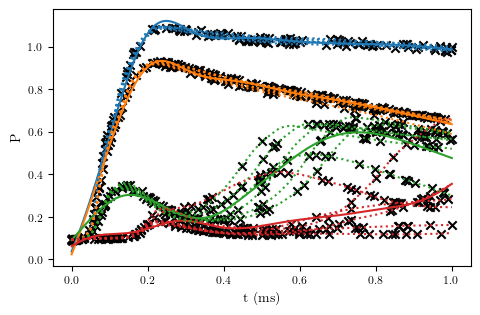

In [131]:
cmap = plt.get_cmap("tab10") 

for j in range(5):
    plt.plot(X_eval[:,0:1][j*len(T):(j+1)*len(T)],u_pred[j*len(T):(j+1)*len(T)])

for i, n in enumerate(N_exp):
    color = cmap(i % 10) 
    for j in range(n):
        idx=(np.sum(N_exp[:i])+j)*len(T)
        plt.plot(X_star[:,0:1][idx:idx+len(T)], P_star[idx:idx+len(T)], color=color, label='Exact', linestyle=':')

plt.scatter(X_u_train_tf[:,0:1], u_train_tf, marker='x', color='black', label=f'data')  

        
plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()


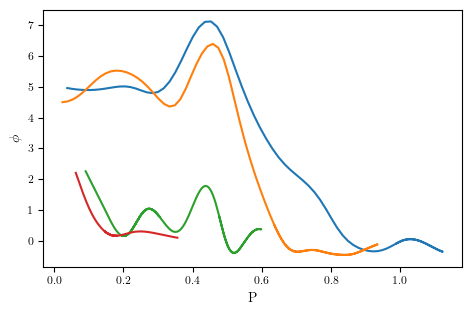

In [134]:
for j in range(4):
    plt.plot(P_eval[:,0:1][j*len(T):(j+1)*len(T)],phi_pred[j*len(T):(j+1)*len(T)])

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('P')
plt.ylabel('$\phi$')
plt.show()

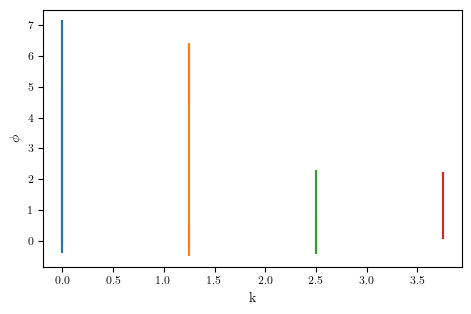

In [136]:
for j in range(4):
    plt.plot(P_eval[:,1:2][j*len(T):(j+1)*len(T)],phi_pred[j*len(T):(j+1)*len(T)])

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('k')
plt.ylabel('$\phi$')
plt.show()

Hacer integracion y continuar

# Symbolic Regresion

In [51]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [52]:
# Fit phi
model_phi.fit(u_star_tf, phi_pred)
print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.010e+04
Head worker occupation: 18.4%
Progress: 92 / 600 total iterations (15.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.622e+00  7.971e+00  y = inv(1.9905)
3           1.585e+00  2.297e-02  y = 0.17128 * x₁
5           1.571e+00  4.496e-03  y = (x₁ * 0.12122) + 0.19923
6           1.494e+00  5.047e-02  y = inv(2.0567 + x₀) * x₁
7           1.247e+00  1.804e-01  y = inv(x₀ + inv(x₀)) * x₁
8           1.204e+00  3.513e-02  y = inv(0.17128) * inv(x₀ + inv(x₀))
9           1.085e+00  1.039e-01  y = inv((x₀ + -1.1811) + inv(x₀)) * x₁
10          5.414e-01  6.956e-01  y = x₀ * (-1.4566 + (inv(x₀ + 1.486) * 12.161))
12          9.405e-04  3.178e+00  y = (((inv(x₀) + -0.1492) * x₀) * (x₁ * x₀)) + -0.0064077
14          9.319e-04  4.604e-03  y = (((inv(x₀) + -0.1492) * x₀) * ((0.0075088 + x₁) * x₀)) + -...
                    

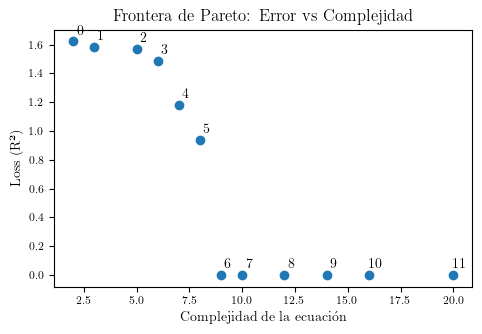

In [53]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

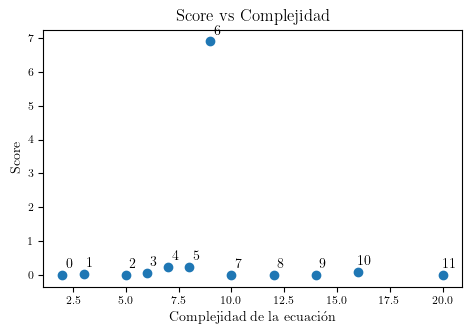

In [54]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [55]:
model_phi.sympy(6)

x0*(-0.14919965*x0*x1 + x1)

In [56]:
symb1=model_phi.predict(u_star_tf,6)

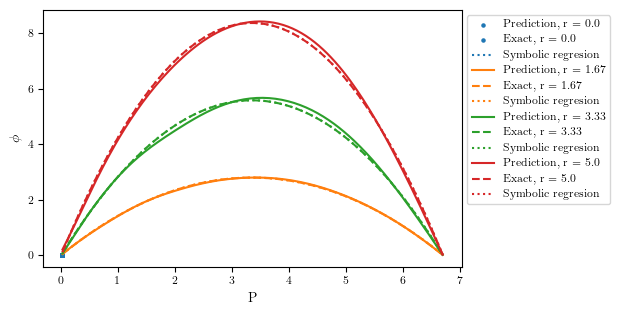

In [57]:
i=0
color = cmap(i % 10)
plt.scatter(P_star[i::len(R)], phi_pred[i::len(R)], color=color, s=5, label='Prediction, '+ f'r = {np.round(R[i],2)}')
plt.scatter(P_star[i::len(R)], phi_star[i::len(R)], color=color, s=5, label='Exact, '+ f'r = {np.round(R[i],2)}')
plt.plot(P_star[i::len(R)], symb1[i::len(R)], linestyle=':', label='Symbolic regresion')

for i in range(1,len(R)):

    color = cmap(i % 10)
    plt.plot(P_star[i::len(R)], phi_pred[i::len(R)], color=color, label='Prediction, '+ f'r = {np.round(R[i],2)}')
    plt.plot(P_star[i::len(R)], phi_star[i::len(R)], color=color,linestyle='--', label='Exact, '+ f'r = {np.round(R[i],2)}')
    plt.plot(P_star[i::len(R)], symb1[i::len(R)], linestyle=':', label='Symbolic regresion')


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('P')
plt.ylabel('$\phi$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [58]:
# Create and train the PySR model
model_dPdT = PySRRegressor(
    niterations=20,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)


In [62]:
# Fit dP_dT
model_dPdT.fit(X_star_tf, u_pred)
print(model_dPdT)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.200e+04
Head worker occupation: 20.4%
Progress: 100 / 300 total iterations (33.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.787e+01  7.971e+00  y = inv(0.93282)
3           5.233e+00  1.228e+00  y = x₁ + 1.4468
5           3.625e+00  1.837e-01  y = x₁ + (0.33351 * x₀)
7           3.434e+00  2.700e-02  y = (x₀ * 0.4641) + (x₁ + -0.90581)
8           2.948e+00  1.524e-01  y = (inv(0.34908 + x₁) * x₀) * x₁
10          2.848e+00  1.732e-02  y = x₁ + inv(0.17494 + inv(x₀ + inv(-0.50158)))
12          2.205e+00  1.279e-01  y = exp((inv(exp(-2.0837) + x₁) * x₀) * 0.29378) * x₁
13          2.199e+00  3.053e-03  y = exp((inv(exp(inv(-0.41165)) + x₁) * x₀) * 0.29378) * x₁
14          2.104e+00  4.387e-02  y = x₁ * exp((x₀ * inv((exp(x₁) + -1.7725) + x₀)) * x₁)
15          1.173e+00  5.845e-01  y = x₁ + inv(exp(inv((x₁ * -0.30115) 

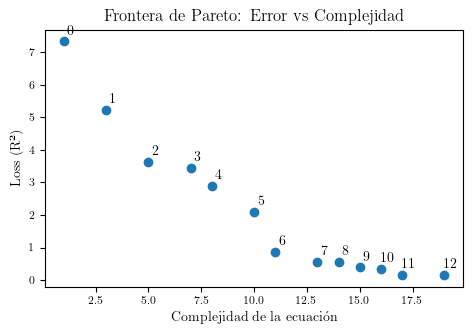

In [63]:
# Extraer las métricas de las ecuaciones
equations_df = model_dPdT.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

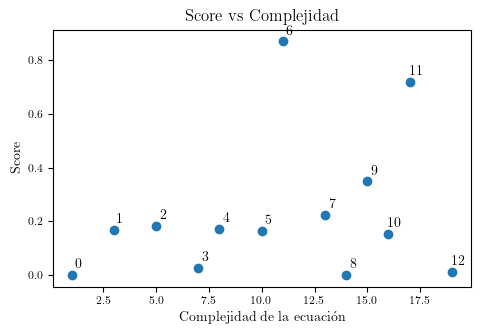

In [64]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [73]:
model_dPdT.sympy(11)

1.0543023 + 1/(0.12878644 + 1/(x0*x1 - 1.1359394))

In [76]:
symb2=model_dPdT.predict(X_star_tf,11)


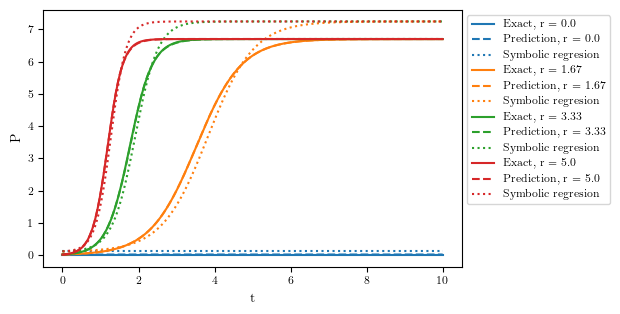

In [77]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(R)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    plt.plot(X_star_tf[:,0:1][i::len(R)], P_star[i::len(R)], color=color, label='Exact, '+ f'r = {np.round(R[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(X_star_tf[:,0:1][i::len(R)], u_pred[i::len(R)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(R[i],2)}') 
    plt.plot(X_star_tf[:,0:1][i::len(R)], symb2[i::len(R)], linestyle=':', label='Symbolic regresion')



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# Adding data

In [121]:
r_symb=np.linspace(0,5,10).reshape([-1,1])
R_meshgrid_symb,T_meshgrid_symb = np.meshgrid(r_symb,t[::10])

In [122]:
X_star_symb = np.hstack((T_meshgrid_symb.flatten()[:,None], R_meshgrid_symb.flatten()[:,None]))
X_star_symb_tf= tf.convert_to_tensor(X_star_symb, dtype=tf.float32)

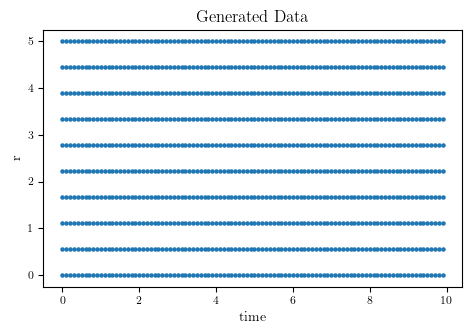

In [123]:
plt.title('Generated Data')
plt.scatter(X_star_symb[:,0:1],X_star_symb[:,1:2], s=5)
plt.xlabel('time')
plt.ylabel('r')
plt.show()

In [124]:
u_pred_symb = predict(X_star_symb_tf, W_p, b_p)

In [125]:
Nt=1000
k_t=K[2]


P_star_symb=np.zeros((Nt, len(r_symb)))
T_star_symb=np.zeros((Nt, len(r_symb)))

for j in range(len(r_symb)):
        dt=0.01
        P_star_symb[0,j]=0.02 #Initial conditions
        T_star_symb[0,j]=0
        for i in range(1,Nt):
            P_star_symb[i,j]=P_star_symb[i-1,j]+ P_star_symb[i-1,j]*r_symb[j]*(1-P_star_symb[i-1,j]/k_t)*dt
            T_star_symb[i,j]=T_star_symb[i-1,j]+dt

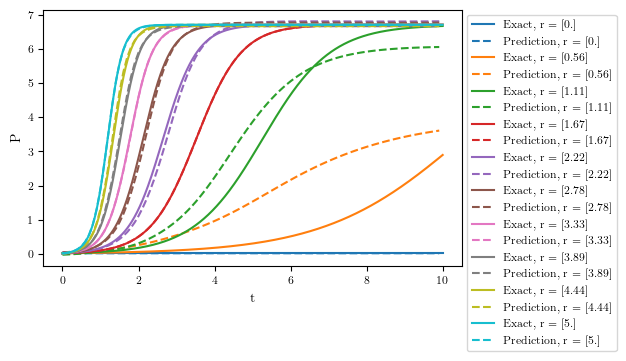

In [126]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(r_symb)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    plt.plot(T_star_symb[:,i], P_star_symb[:,i], color=color, label='Exact, '+ f'r = {np.round(r_symb[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(X_star_symb_tf[:,0:1][i::len(r_symb)], u_pred_symb[i::len(r_symb)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(r_symb[i],2)}') 
    # # Graficar datos con el mismo color
# plt.scatter(X_u_train_tf[:,0:1], u_train_tf, marker='x', color='black', label=f'data')  



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [127]:
# Create and train the PySR model
model_dPdT_data = PySRRegressor(
    niterations=50,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [128]:
# Fit dP_dT
model_dPdT_data.fit(X_star_symb_tf, u_pred_symb)
print(model_dPdT_data)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.660e+05
Head worker occupation: 47.2%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 357 / 750 total iterations (47.600%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.313e+00  1.594e+01  y = x₁
2           8.205e+00  1.305e-02  y = exp(1.4396)
3           5.358e+00  4.263e-01  y = 1.7191 + x₁
5           3.037e+00  2.838e-01  y = x₁ + (0.40085 * x₀)
6           3.037e+00  -0.000e+00  y = x₁ + (inv(2.4947) * x₀)
7           2.760e+00  9.554e-02  y = -1.0443 + (x₁ + (x₀ * 0.55829))
9           2.752e+00  1.620e-03  y = ((x₁ * 1.0593) + (x₀ * 0.55829)) + -1.1925
10          2.206e+00  2.210e-01  y = 4.7437 + ((inv(x₀ + 2.2684) * -19.819) + x₁)
12          2.078e+00  2.992e-02  y = (4.7437 + ((inv(x₀ + 2.2684) * -19.819) + x₁)) * 1.0679
13        

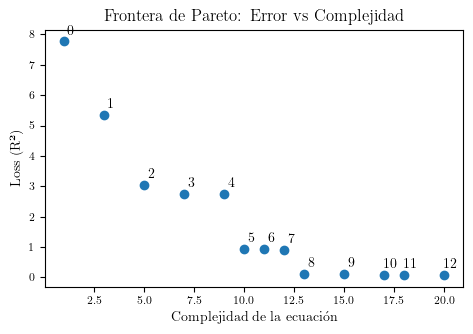

In [129]:
# Extraer las métricas de las ecuaciones
equations_df = model_dPdT_data.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

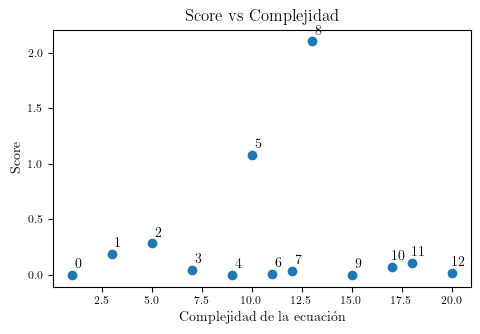

In [130]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [131]:
model_dPdT_data.sympy(8)

6.7455177 - 314.6875/(exp(0.69892794*x0*x1) + 45.328304)

In [132]:
symb_aug=model_dPdT_data.predict(X_star_symb_tf,8)


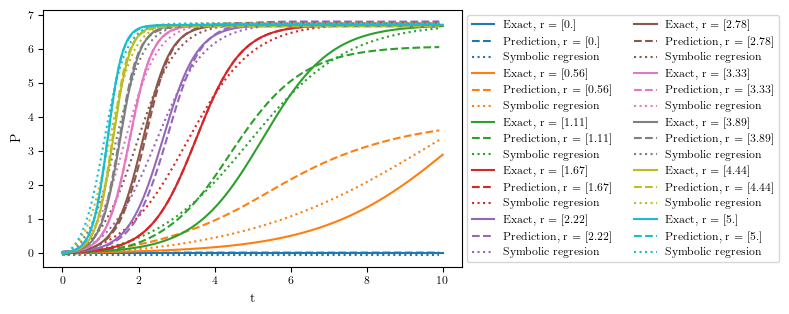

In [133]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(r_symb)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    # plt.plot(X_star_symb_tf[:,0:1][i::len(R)], P_star[i::len(R)], color=color, label='Exact, '+ f'r = {np.round(R[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(T_star_symb[:,i], P_star_symb[:,i], color=color, label='Exact, '+ f'r = {np.round(r_symb[i],2)}')
    plt.plot(X_star_symb_tf[:,0:1][i::len(r_symb)], u_pred_symb[i::len(r_symb)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(r_symb[i],2)}') 
    plt.plot(X_star_symb_tf[:,0:1][i::len(r_symb)], symb_aug[i::len(r_symb)], linestyle=':', label='Symbolic regresion')



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

plt.show()